# scRNA-Seq Analysis

We have written a workflow for analyzing gene expression through development. We use the Scanpy Python package for analyzing the scRNA-seq data, and we use the Stream package to conduct pseudotime analysis. The main steps of our data analysis are quality-control, normalization, global clustering, pseudotime analysis, and pathway cluster analysis.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
from matplotlib import cm, colors
from matplotlib.figure import Figure
from matplotlib.backend_bases import FigureCanvasBase

import matplotlib.font_manager
matplotlib.rcParams['font.family'] = "calibri"

import scipy.cluster.hierarchy as sch
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

import module_mainfxns as nk

import panel as pn
pn.extension()

from glob import glob

import stream as st
import networkx as nx

In [2]:
# Specify the figure directory and the file for storing the AnnData object.

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
sc.settings.figdir = './epithelial_mesenchymal_transition/forebrain/figures'

st.set_figure_params(rc={'image.cmap': 'viridis'})

datadir= './epithelial_mesenchymal_transition/data/'
figdir = './epithelial_mesenchymal_transition/forebrain/figures/'
results_file = './epithelial_mesenchymal_transition/forebrain/results/forebrain.h5ad'  # the file that will store the analysis results
resdir = './epithelial_mesenchymal_transition/forebrain/results/'

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.7.0


In [3]:
# Import the gene expression matrix! (This process depends on the format of the data given in the paper.)

files = datadir+'matrix.csv'
adata = sc.read_csv(files).T
adata

AnnData object with n_obs × n_vars = 1916 × 23154

[Hu et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1416-2) sequenced several tissues in two biological replicates from E9.5-E11.5 days in mouse development, and here, we analyze the sequenced forebrain tissues from their dataset.

GEO Accession: [GSE87038](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi)

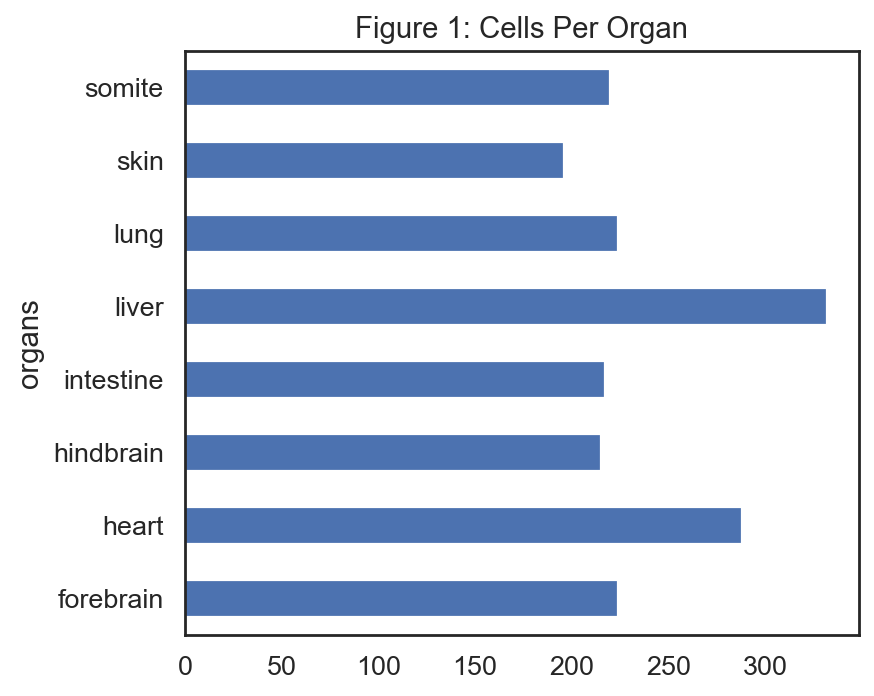

In [4]:
organ = []
for name in list(adata.obs.index):
    if 'forebrain' in name:
        organ.append('forebrain')
    elif 'heart' in name:
        organ.append('heart')
    elif 'intestine' in name:
        organ.append('intestine')
    elif 'liver' in name:
        organ.append('liver')
    elif 'hindbrain' in name:
        organ.append('hindbrain')
    elif 'somite' in name:
        organ.append('somite')
    elif 'lung' in name:
        organ.append('lung')
    elif 'skin' in name:
        organ.append('skin')
adata.obs['organs'] = organ

df = pd.DataFrame(adata.obs, columns = ['organs'])
orgs = df.pivot_table(index = ['organs'], aggfunc = 'size')
ax = orgs.plot.barh(title='Figure 1: Cells Per Organ')
fig = ax.get_figure()
fig.savefig(figdir+'fig1.pdf')

The histogram above shows that the forebrain dataset is quite small, which is fine if the sequencing is of high-quality.

The paper provides additional metadata for the dataset. In their analysis of hindbrain data, they labeled biological replicates, deveopmental stage, and neuronal cells. We will annotate our AnnData object with these labels as well.

In [5]:
# Labeling batches here

batch = []
for name in list(adata.obs.index):
    if 'E9.5_embryo1' in name:
        batch.append('E9.5_embryo1')
    elif 'E9.5_embryo2' in name:
        batch.append('E9.5_embryo2')
    elif 'E9.5_embryo3' in name:
        batch.append('E9.5_embryo3')
    elif 'E10.5_embryo1' in name:
        batch.append('E10.5_embryo1')
    elif 'E10.5_embryo2' in name:
        batch.append('E10.5_embryo2')
    elif 'E11.5_embryo1' in name:
        batch.append('E11.5_embryo1')
    elif 'E11.5_embryo2' in name:
        batch.append('E11.5_embryo2')

adata.obs['batch'] = batch

In [6]:
# Choosing cells labeled as forebrain cells in the paper

forebrain = (adata[adata.obs['organs'] == 'forebrain'])

# Choosing cells defined only as neuronal cells (NC) in the paper

cell_assign = pd.read_csv(datadir+'cell_assignments.csv')
new_header = cell_assign.iloc[0]
cell_assign = cell_assign[1:]
cell_assign.columns = new_header

nc_cell_list = [cell for cell in list(forebrain.obs.index) if cell  in list(cell_assign[cell_assign['Cluster'] == 'NC']['Cell'])]
forebrain = forebrain[nc_cell_list, :]

### Pre-Processing

Our data pre-processing begins with quality control. Below, we visualize our data prior to processing.

Trying to set attribute `.obs` of view, copying.


normalizing counts per cell
    finished (0:00:00)


... storing 'organs' as categorical
... storing 'batch' as categorical


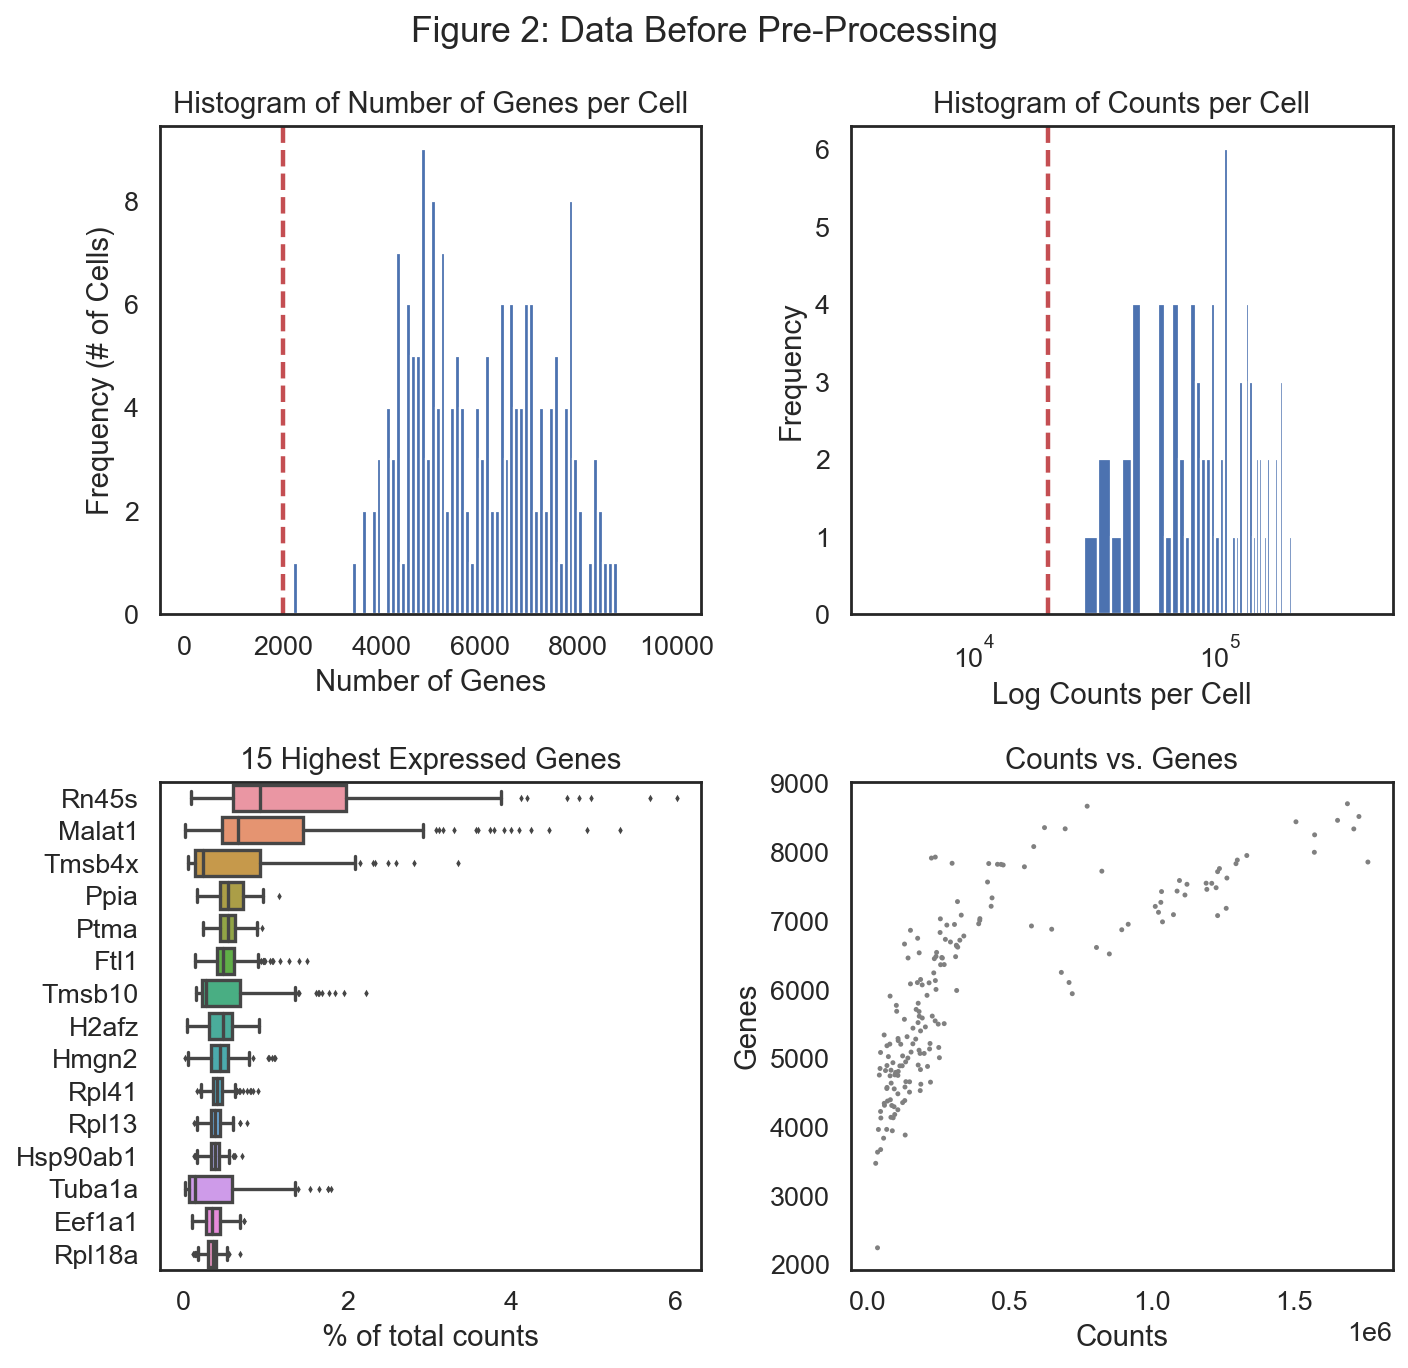

In [7]:
sc.pp.filter_cells(forebrain, min_genes=0)
sc.pp.filter_genes(forebrain, min_cells=0)

# Total counts, cells per gene, and mitochondrial genes
X = np.matrix(forebrain.X)
forebrain.obs['n_total_counts_per_cell'] = (X.sum(axis=1).A1)
forebrain.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
forebrain.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

pre_processed = nk.vis_pre_processing(forebrain, genes_range=(0, 10000),
    counts_range=(0, 400000),title='Figure 2: Data Before Pre-Processing')
pre_processed.savefig(figdir+"fig2.pdf")

In [8]:
avg_genes = np.average(forebrain.obs['n_genes_per_cell'])
avg_counts = np.average(forebrain.obs['n_total_counts_per_cell'])

print('The average number of genes per cell is ' + str(int(avg_genes)) 
      + ' and the average number of counts per cell is ' 
      + str(int(avg_counts)))

The average number of genes per cell is 6005 and the average number of counts per cell is 406281


The plots above allow us to visualize parameters for our data set, including the number of unique cells and genes captured in the data set, and the distributions of the total number of counts per cell, the total numbers of genes per cell, and the total number of cells per gene. These will allow us to determine our parameters for filtering our data set so we can retain only cells and genes desired.

Below, we adjust the parameters for filtering our cells (based on minimum total counts and the minimum number of genes per cell) and our genes (based on the minimum number of cells the gene is detected in). A high-quality data set for cells has an average of 20,000 counts per cell,  1000-2000 genes per cell, and about 3,000 cells per gene. We can filter genes as some fraction of the total cell count.

filtered out 9245 genes that are detected in less than 3 cells


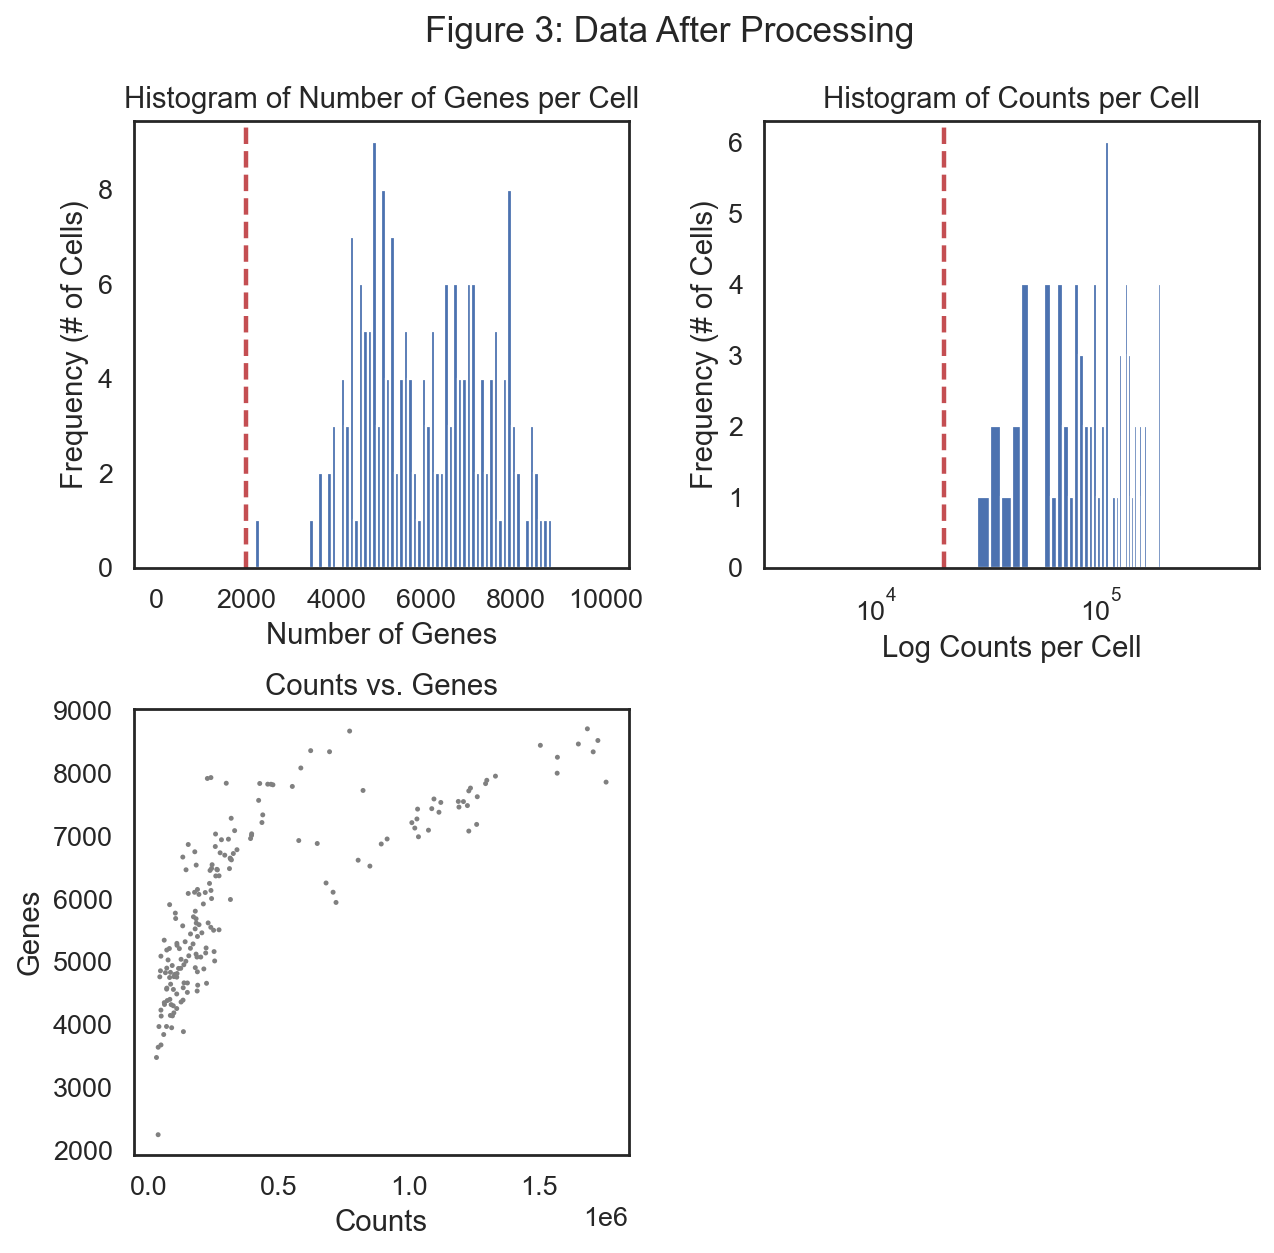

In [9]:
forebrain = nk.filter_data(forebrain, min_counts=2000, min_genes=2000, min_cells=3)
post_processing = nk.vis_post_processing(forebrain, genes_range=(0, 10000), counts_range=(0, 400000),
                                         title='Figure 3: Data After Processing')
post_processing.savefig(figdir+"fig3.pdf")

Below, we select genes below a certain number of counts. We should note that transcript counts differ between cells, so a comparison of gene expression using total counts would be biased toward cells with higher total counts. To appropriately compare gene expression, we normalize the count data by scaling it based on total counts. For downstream analysis, we normalize the data using a log(x+1) transformation on the number of counts per cell. 

Yet, Hu et al. use a log (x/10 + 1) normalization in their paper, so that is what we apply here.

In [10]:
forebrain = forebrain[forebrain.obs.n_genes < 10000, :] 
forebrain=nk.normalize_data(forebrain, 1.75e5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/niveditakanrar/anaconda3/envs/env_stream/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Below, we select for two types of genes

1. Genes that are highly variable, and thus are informative when analyzing cellular heterogeneity
2. Genes of interest: Bmp, Wnt, and Notch pathway genes, and marker genes specified in the paper

First, we should note that both of these groups include genes that pass our quality-control filters.

The first group of genes is already accounted for when we make our gene expression matrix "dense," but the second group of genes does not necessarily overlap with the first group. We "force" our gene expression matrix to keep these genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell. We then scale our data set by centering each gene's expression with zero mean and unit variance, and filter out any genes whose standard deviation for expression is greater than 10. 

In [11]:
wnt_ligands = nk.get_genes(forebrain, nk.wnts)
wnt_receptors = nk.get_genes(forebrain, nk.wntr)
bmp_ligands = nk.get_genes(forebrain, nk.bmps)
bmp_receptors = nk.get_genes(forebrain, nk.bmpr)
notch = nk.get_genes(forebrain, nk.notch)

# Get this from the paper!
markers = ['2810004N23Rik', '3110039M20Rik', 'AI854517', 'Adarb2', 'Bcl11a',
       'Cacna2d1', 'Dkc1', 'Dlx1', 'Dlx1as', 'Dlx2', 'Dlx5', 'Dlx6os1',
       'Efnb1', 'Eif4ebp1', 'Emb', 'Eno1b', 'Eomes', 'Foxg1', 'Fyn',
       'Gad2', 'Gar1', 'Gja1', 'Gm12657', 'Hmga2', 'Id4', 'Igfbpl1',
       'Lhx2', 'Lhx9', 'Metrn', 'Mpped2', 'Neurod1', 'Nhp2', 'Nr2e1',
       'Oxct1', 'Prmt1', 'Prps1', 'Ptprz1', 'Raly', 'Serpinh1', 'Sfrp1',
       'Slc17a6', 'Sorbs2', 'Sox9', 'Spry1', 'Tbr1', 'Tcof1', 'Wdr43',
       'Wfdc2', 'Zic3']

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch}

all_genes = [wnt_ligands, wnt_receptors, bmp_ligands, bmp_receptors, notch, markers]

forebrain=nk.merge_genes(forebrain, all_genes)
forebrain=nk.scale_data(forebrain)

regressing out ['n_total_counts_per_cell']
    finished (0:00:23)


### Principal component analysis

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

In [12]:
forebrain

AnnData object with n_obs × n_vars = 184 × 3298
    obs: 'organs', 'batch', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
Figure 4


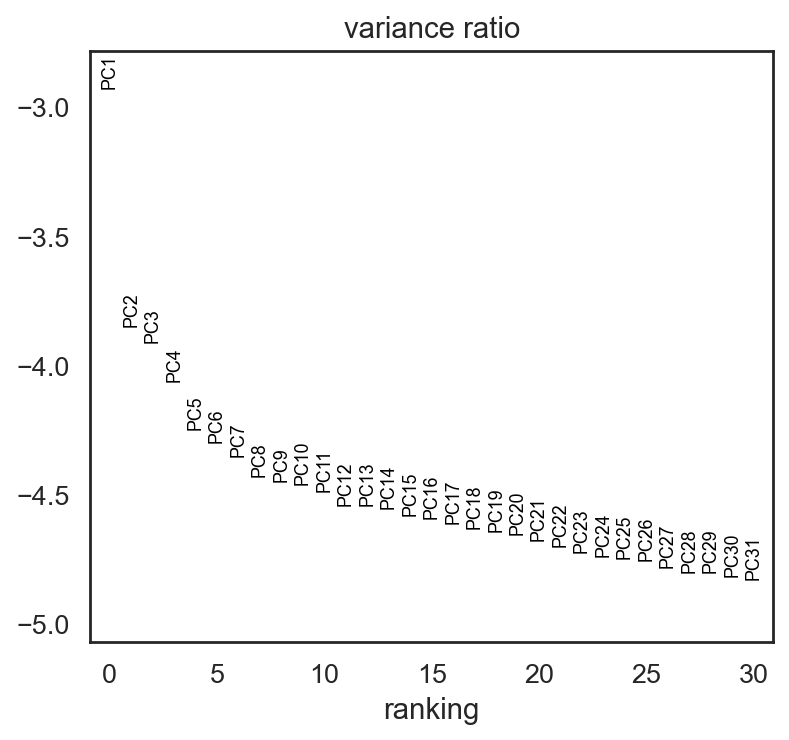

AnnData object with n_obs × n_vars = 184 × 3298
    obs: 'organs', 'batch', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [13]:
forebrain = sc.pp.pca(forebrain, svd_solver='arpack', n_comps=50, return_info=True, copy=True)

pca = forebrain.uns['pca']
xpca = forebrain.obsm['X_pca']
vr = forebrain.uns['pca']['variance_ratio']

print('Figure 4')
sc.pl.pca_variance_ratio(forebrain, log=True, save='_fig4.pdf')

# Save these results
#forebrain.write(results_file)
forebrain

### Computing the Neighborhood Graph and UMAPs

To acccount for differences between the two biological replicates for each developmental stage sequenced, we batch-correct the data with the BBKNN algorithm.

In [14]:
# We batch correct on the two replicates for each of the three stages.

from anndata import AnnData
adatas = [forebrain[forebrain.obs['batch'] == i].copy() for i in 
         ['E9.5_embryo1', 'E9.5_embryo2', 'E10.5_embryo1',
         'E10.5_embryo2', 'E11.5_embryo1', 'E11.5_embryo2']]

adatas[0].obs['batches'] = 'E9.5_embryo1'
adatas[1].obs['batches'] = 'E9.5_embryo2'
adatas[2].obs['batches'] = 'E10.5_embryo1'
adatas[3].obs['batches'] = 'E10.5_embryo2'
adatas[4].obs['batches'] = 'E11.5_embryo1'
adatas[5].obs['batches'] = 'E11.5_embryo2'
e95 = AnnData.concatenate(adatas[0], adatas[1])
e105 = AnnData.concatenate(adatas[2], adatas[3])
e115 = AnnData.concatenate(adatas[4], adatas[5])
sc.external.pp.bbknn(e95, 'batch')
sc.external.pp.bbknn(e105, 'batch')
sc.external.pp.bbknn(e115, 'batch')

forebrain = AnnData.concatenate(e95, e105, e115)
forebrain.obs['batch'].replace(['0', '1', '2'], ['E9.5', 'E10.5', 'E11.5'], inplace = True)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [15]:
sc.pp.neighbors(forebrain, n_neighbors=10, n_pcs=30)
sc.tl.umap(forebrain)
sc.tl.draw_graph(forebrain)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:00)


### Clustering

We can use the Leiden method for clustering our data.

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'batch' as categorical
... storing 'batches' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or R

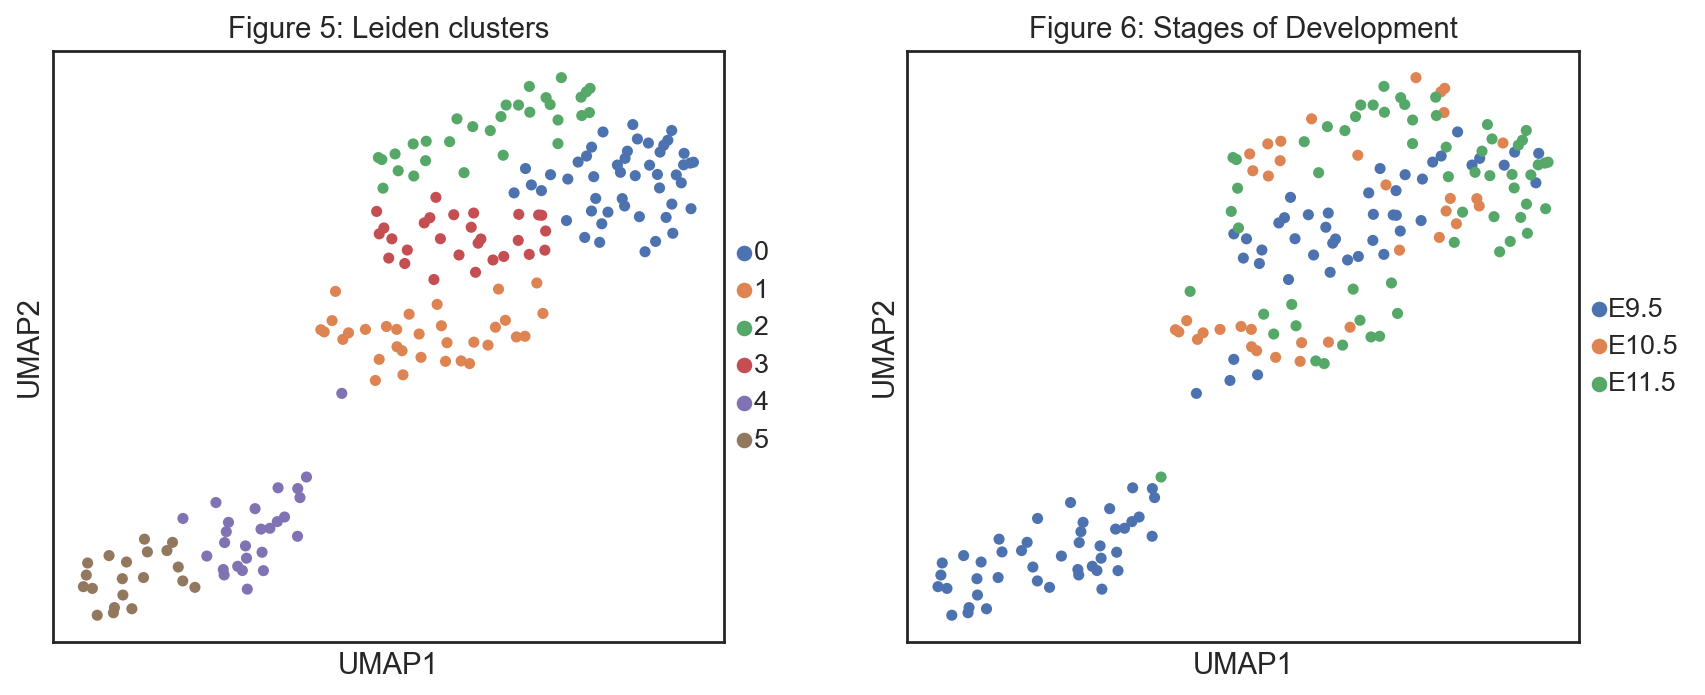

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

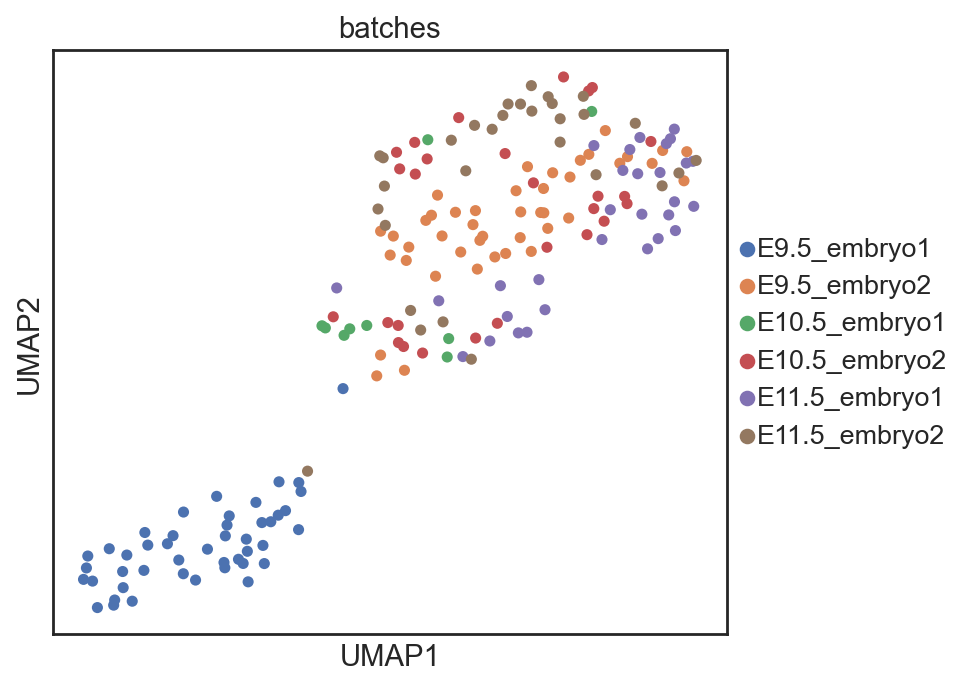

In [16]:
sc.tl.leiden(forebrain)
forebrain.write(results_file)
sc.pl.umap(forebrain, color=['leiden','batch'], title=['Figure 5: Leiden clusters', 'Figure 6: Stages of Development'],
           save = '_fig5.pdf', size=100)

sc.pl.umap(forebrain,color='batches', size=100)

### Marker Genes and Cell Type Clustering

We need to annotate the cell types our clusters correspond to. Hu et al. provide marker genes for cell type, and we can score for cell type based on mean expression of these marker genes across each cluster. 

In [17]:
df = pd.read_csv(datadir+'forebrain_markers.csv', header=None, index_col=0)
marker_genes = {'NEC' : list(df.loc['NEC 1']) + list(df.loc['NEC 2']),
                'RGC' : list(df.loc['RGC']),
                'NPC' : list(df.loc['NPC']),
                'IPC' : list(df.loc['IPC'])
               }
nk.evaluate_partition(forebrain, marker_genes)

0         1         2         3         4         5
NEC -0.527514  0.106202 -0.512860  0.021233  0.788286  0.810902
RGC -0.183718  0.753309 -0.272585 -0.032272 -0.193160 -0.059206
NPC  0.770107 -0.276187 -0.102541 -0.124961 -0.538936 -0.376983
IPC  0.117595 -0.285219  0.986452 -0.115183 -0.588586 -0.379138

... storing 'cell_type' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* arg

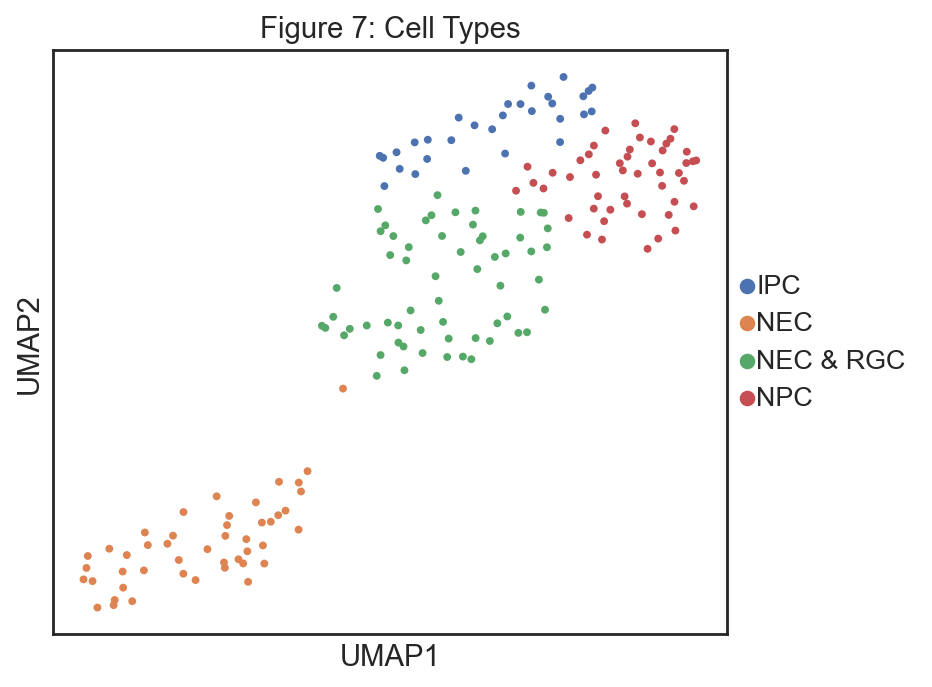

In [18]:
# Actually label the leiden clusters with the cell types we computed.

old_to_new = {
    '0': 'NPC',
    '1': 'NEC & RGC',
    '2': 'IPC',
    '3': 'NEC & RGC',
    '4': 'NEC',
    '5': 'NEC',
}

forebrain.obs['cell_type'] = forebrain.obs['leiden'].replace(old_to_new)

sc.pl.umap(forebrain, color='cell_type', size=50, title='Figure 7: Cell Types')

## Stream Analysis

We conduct our pseudotime analysis with the Stream package. We first need to generate the dimensionality reduction in Stream (whose results should be similar to those from our UMAP projection in Scanpy). Next, we get the graph of clutser connectivities, and obtain the pseudotime data for downstream analysis.

In [19]:
st.set_workdir(forebrain,'./stream_result')

Saving results in: ./stream_result


Figure 8: PCA Variance Ratio
using all the features ...
30 PCs are selected


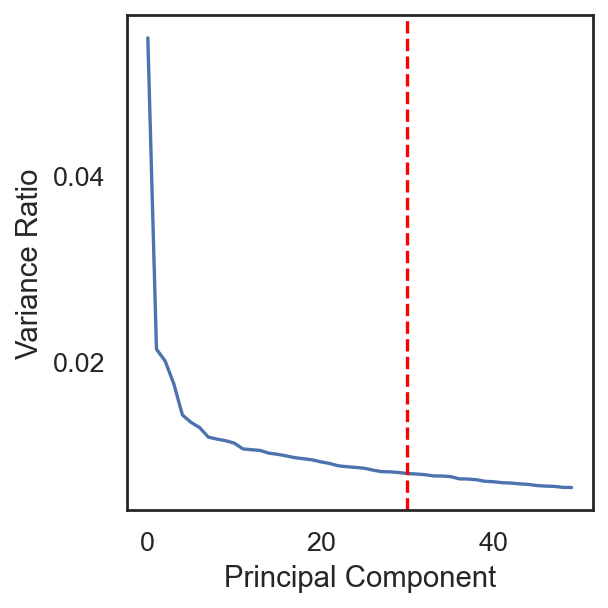

In [20]:
print('Figure 8: PCA Variance Ratio')
st.select_top_principal_components(forebrain,n_pc=30,first_pc=True, max_pc=50)

In [21]:
st.dimension_reduction(forebrain,method='umap',feature='top_pcs',n_neighbors=9, 
                       n_components=2)

feature top_pcs is being used ...
1 cpus are being used ...


Figure 9-11: Stream Dimensionality Reduction


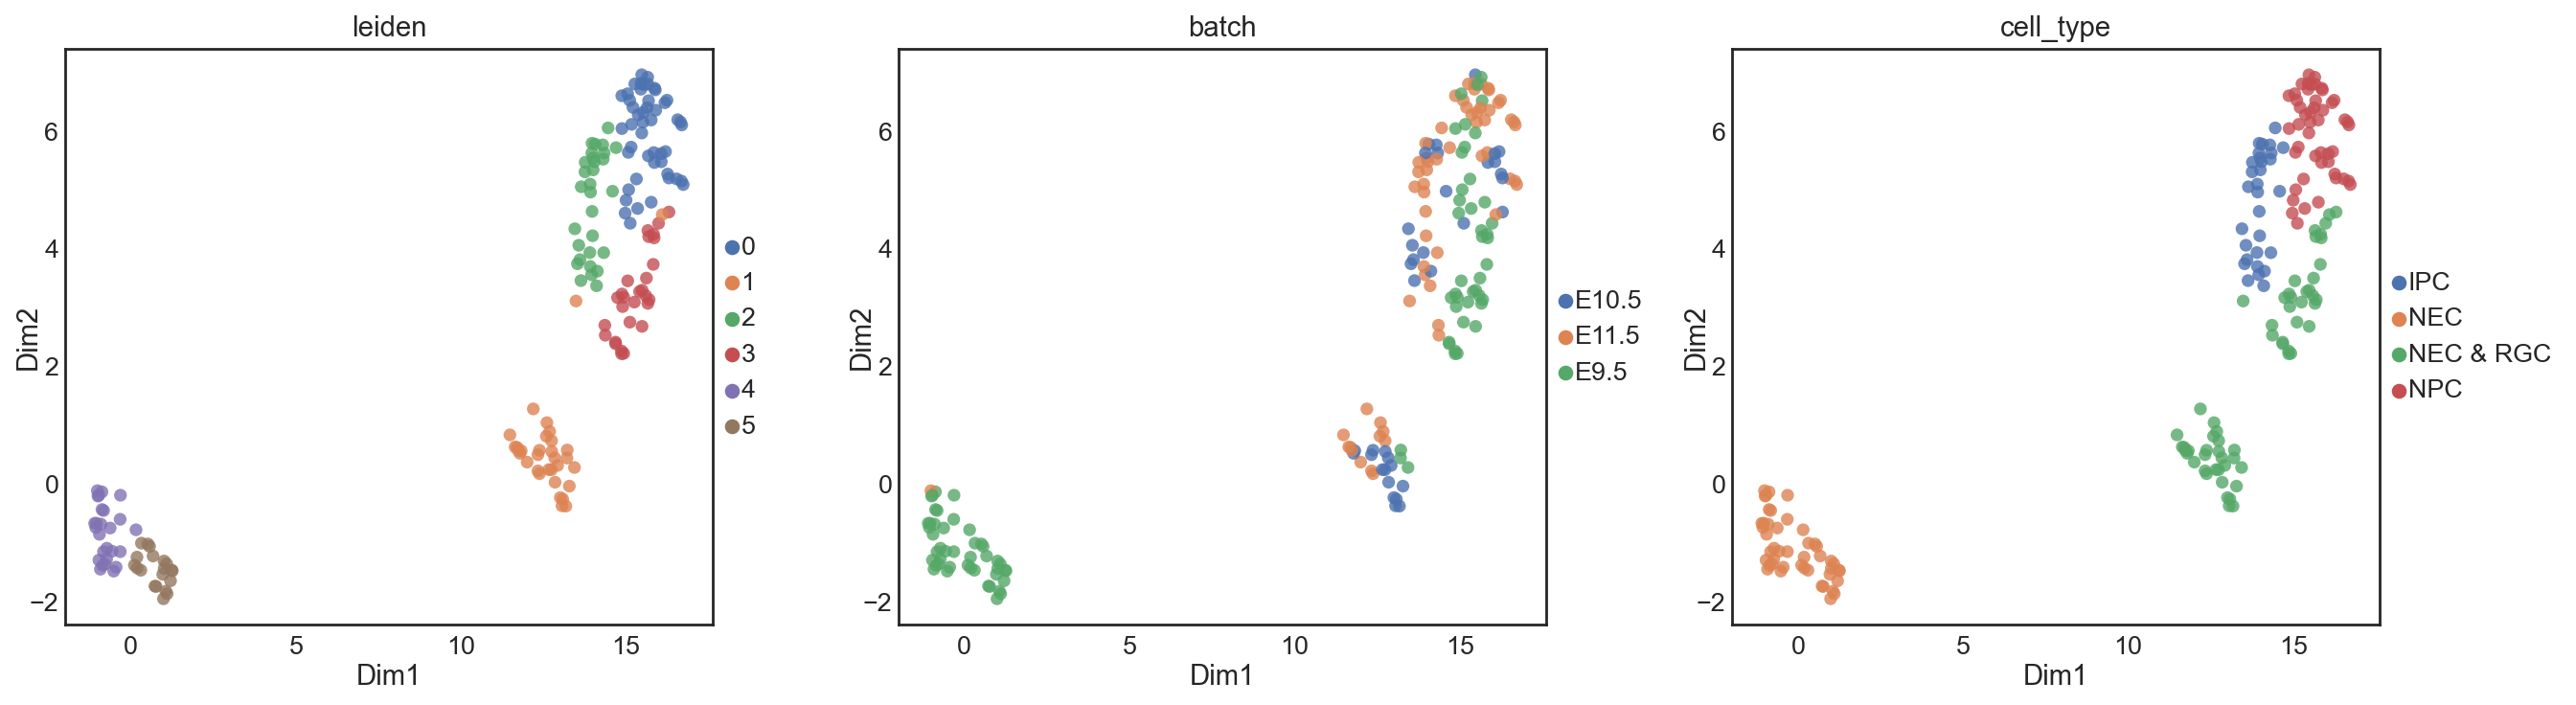

In [22]:
print('Figure 9-11: Stream Dimensionality Reduction')
st.plot_dimension_reduction(forebrain,color=['leiden', 'batch', 'cell_type'],
                            n_components=2,show_graph=False,show_text=False)

In [23]:
# We compute the graph of connectivities between the clusters with this function.

st.seed_elastic_principal_graph(forebrain,n_clusters=12)

Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 12
Calculatng minimum spanning tree...
Number of initial branches: 3


Figures 12-14: Stream Elastic Principal Graph


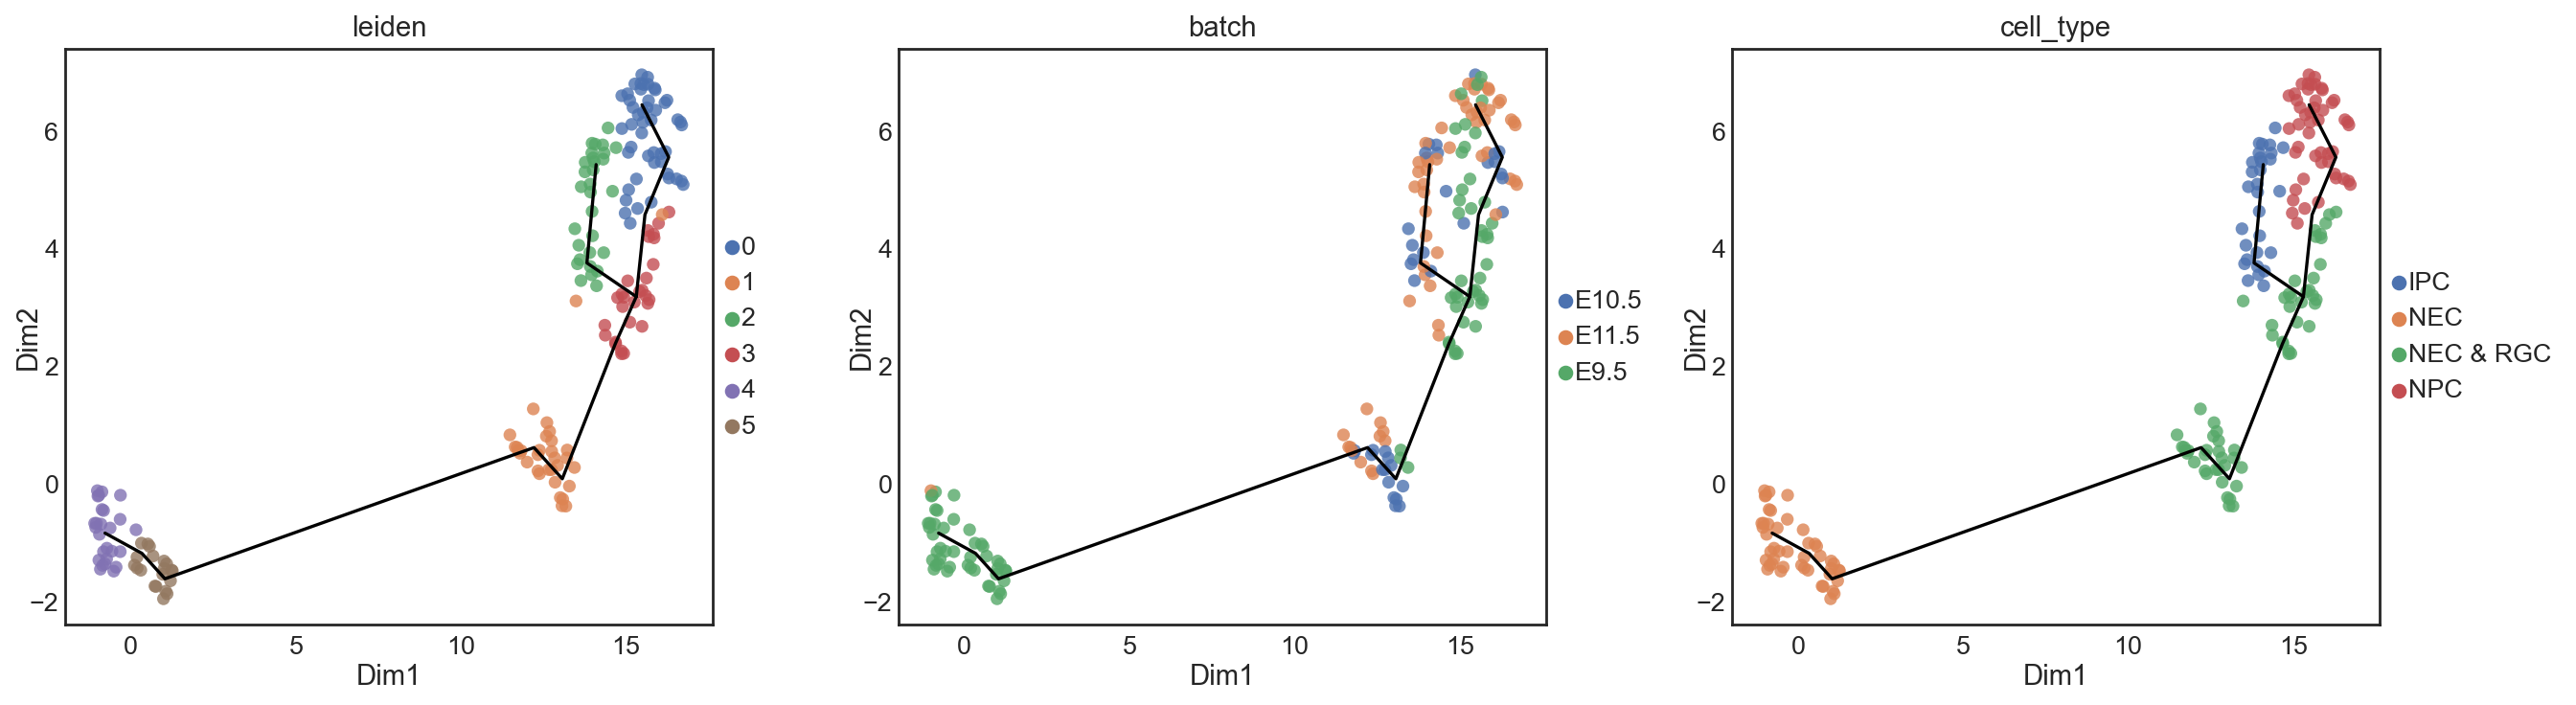

In [24]:
# Below, we plot the connectivities.

print('Figures 12-14: Stream Elastic Principal Graph')
st.plot_dimension_reduction(forebrain,color=['leiden', 'batch', 'cell_type'],n_components=2,
                            show_graph=True,show_text=False)
#st.plot_branches(forebrain,show_text=True)

In [25]:
trajectories = {'trajectory1': [('S1', 'S0'), ('S2', 'S0')],
               'trajectory2': [('S2', 'S0'), ('S3', 'S0')]}

sorted_keys = sorted(trajectories.keys())

print('NEC: Neural epithelial cells \nRGC: Radial glial cell \nNPC: Neural \
progenitor cell \nIPC: Interneuron precursor cell\n')

print('We have ' + str(len(sorted_keys)) + ' trajectories. ' + sorted_keys[0] + ' ' 
      + str(list(forebrain[forebrain.obs['branch_id_alias'].isin(trajectories[sorted_keys[0]])].obs['cell_type'].unique()))
      + ' & '  + sorted_keys[1] + ' ' +
     str(list(forebrain[forebrain.obs['branch_id_alias'].isin(trajectories[sorted_keys[1]])].obs['cell_type'].unique())))


NEC: Neural epithelial cells 
RGC: Radial glial cell 
NPC: Neural progenitor cell 
IPC: Interneuron precursor cell

We have 2 trajectories. trajectory1 ['NEC', 'NEC & RGC', 'NPC'] & trajectory2 ['NEC', 'NEC & RGC', 'IPC']


### Signaling Pathways

Our goal is to understand the dynamics of gene expression through development, which we evaluate by identifying motifs in gene expression of developmental pathways. We identify these "motifs" by clustering our leiden clusters based on cosine distance of gene expression for each pathway. We evaluate the optimal number of clusters using silhouette scores.

... storing 'kmeans' as categorical
... storing 'branch_id' as categorical
... storing 'branch_id_alias' as categorical
... storing 'Wnt Ligands' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Column
    [0] Markdown(str, align='center', style={'font-family': '...})
    [1] Markdown(str, align='center', style={'font-family': '...})
    [2] Column(align='center')
        [0] Row(align='center')
            [0] Column(align='center')
                [0] ParamFunction(function)
                [1] ParamFunction(function)
            [1] Column(align='center')
                [0] Column(align='center')
                    [0] Select(name='Pathway', options=['Wnt Ligands', ...], value='Wnt Ligands', width=150)
                    [1] IntSlider(end=5, name='Number of Pathway C..., start=2, value=2, width=250)
                [1] Spacer(height=10)
                [2] ParamFunction(function)
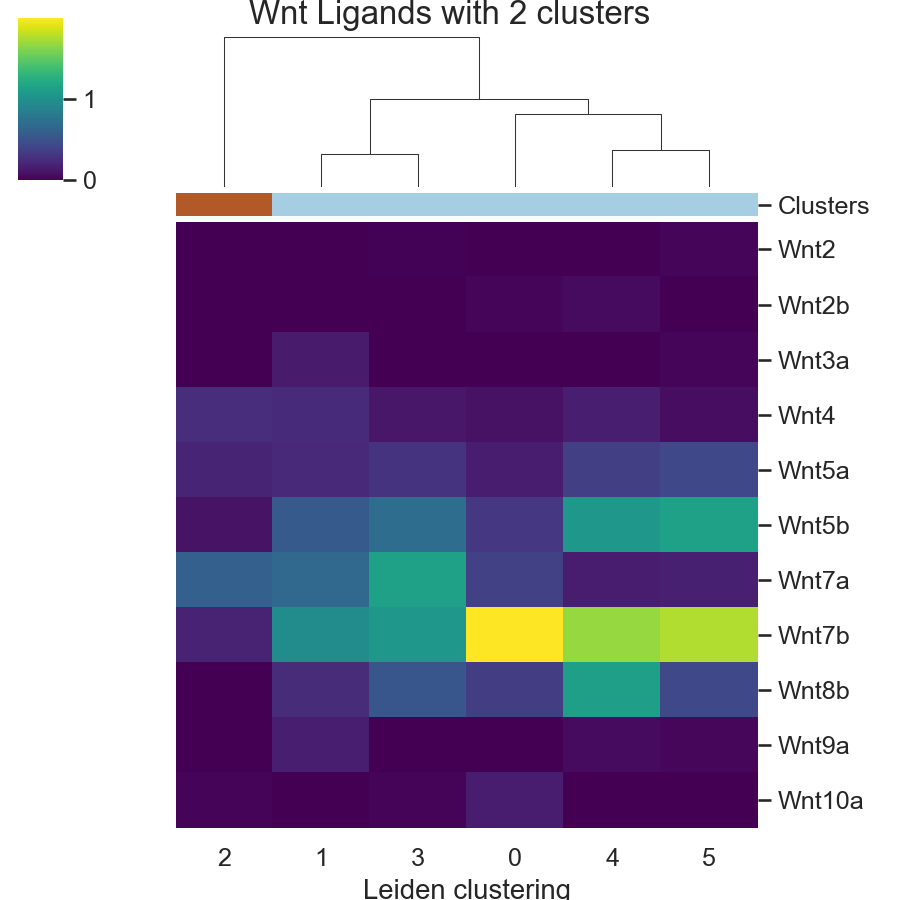
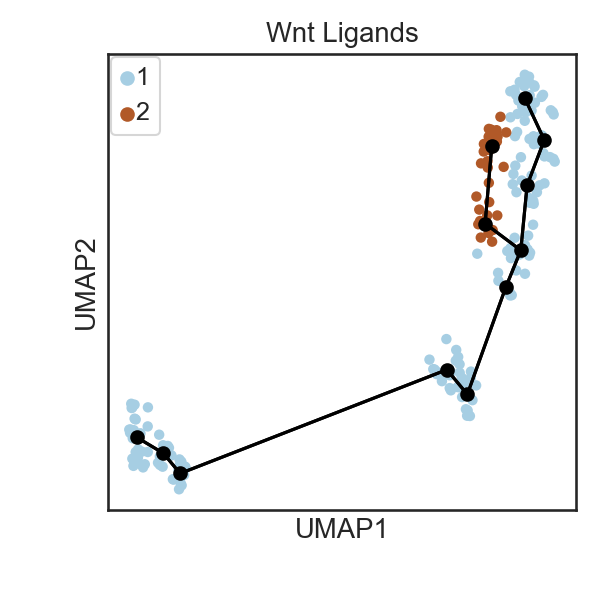
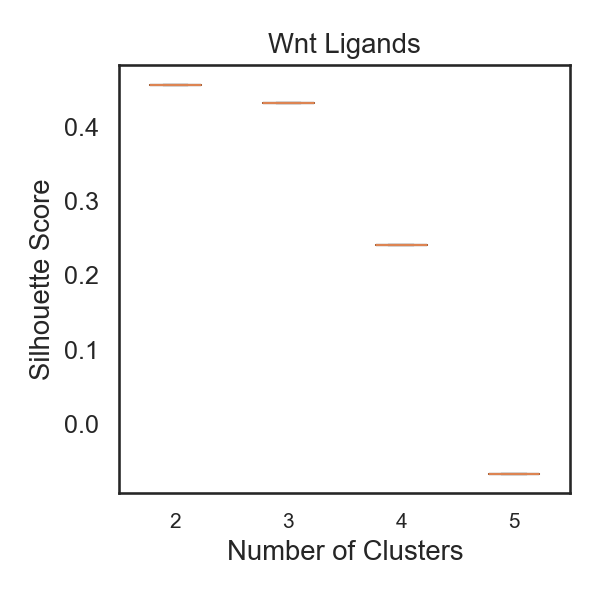

In [26]:
epg = forebrain.uns['epg']
nodes = nx.get_node_attributes(epg, 'pos')

ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(forebrain.obs['leiden'].unique())-1,
                                 width=250)

@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    fig = nk.silhouette_plots(forebrain, ticker_val, genes)[0]
    fig.set_size_inches(4,4)
    plt.close()
    fig.savefig(figdir+"fig6_silhouette_"+ticker_val+'.pdf')
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    xyz = nk.heatmap(forebrain, genes, slider_val, ticker_val, norm=True)
    g = xyz[0]
    g.set_size_inches(6,6)
    plt.close()
    g.savefig(figdir+"fig6_heatmap_"+ticker_val+'.pdf')
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    #st.plot_dimension_reduction(forebrain,color=[ticker_val],n_components=2,show_graph=True,show_text=False)
    sc.pl.umap(forebrain, color = ticker_val, ax=ax, show=True, size = 100)#, palette=forebrain.uns[ticker_val+'_colors'])
    for i in epg.nodes:
        ax.scatter(nodes[i][0], nodes[i][1], color='black')
        edges = list(epg.edges(i))
        for j in edges:
            ax.plot([nodes[j[0]][0],nodes[j[1]][0]], [nodes[j[0]][1],nodes[j[1]][1]], color='black')
    ax.legend()
    ax.set_title(ticker_val)
    fig.savefig(figdir+"fig7_"+ticker_val+'.pdf')
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Figure 15: Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("Select the ideal number of clusters \
                                          for each pathway before running cells \
                                          below. It takes a while to \
                                          generate the silhouette plots.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Column
    [0] Markdown(str, align='center')
    [1] Markdown(str, align='center')
    [2] Row
        [0] ParamFunction(function)
        [1] Row
            [0] Select(name='Label', options=['leiden', 'batch', ...], value='leiden', width=150)
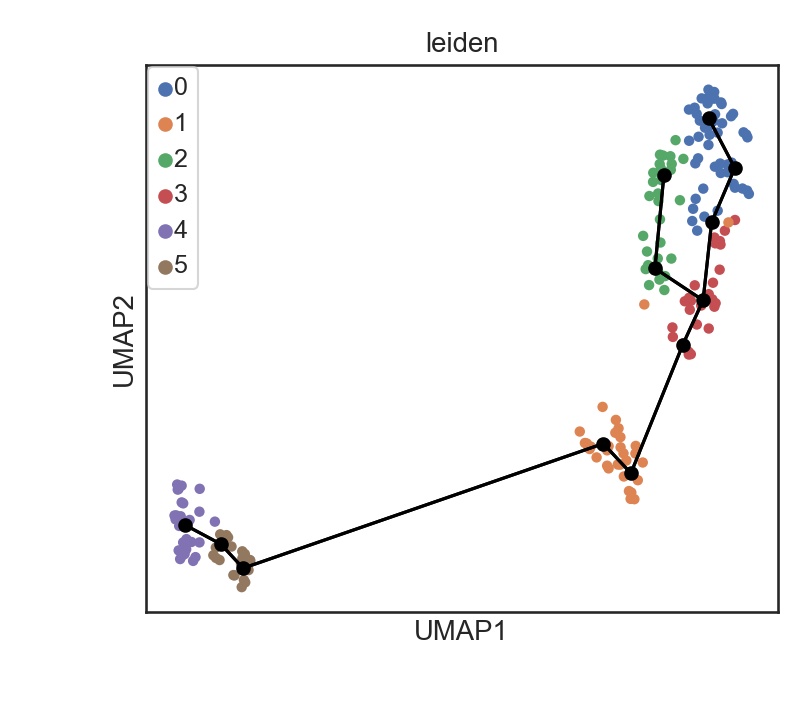

In [27]:
tickers = ['leiden', 'batch', 'cell_type', 'S2_pseudotime']+list(pathways.keys())
ticker = pn.widgets.Select(name='Label', options=tickers, width=150)

@pn.depends(ticker.param.value)

def get_umap(ticker_val):
    fig = Figure()
    ax = fig.subplots()
    FigureCanvasBase(fig)
    #st.plot_dimension_reduction(forebrain,color=[ticker_val],n_components=2,show_graph=True,show_text=False)
    sc.pl.umap(forebrain, color = ticker_val, ax=ax, show=True, size = 100)
    for i in epg.nodes:
        ax.scatter(nodes[i][0], nodes[i][1], color='black')
        edges = list(epg.edges(i))
        for j in edges:
            ax.plot([nodes[j[0]][0],nodes[j[1]][0]], [nodes[j[0]][1],nodes[j[1]][1]], color='black')
    ax.legend()
    ax.set_title(ticker_val)
    fig.savefig(figdir+"fig7_"+ticker_val+'.pdf')
    return fig


pn.Column(pn.pane.Markdown("##Figure 16: Forebrain UMAPs", align="center"),
          pn.pane.Markdown("We can visualize the leiden clustering, batches, cell types, and pathway clusters \
                           for the whole forebrain dataset.", align = 'center'),
          pn.Row(get_umap, pn.Row(ticker)))

In [28]:
# This is just for formatting.

css = '''
.panel-widget-box {
  background: #f0f0f0;
  border-radius: 5px;
  border: 1px black solid;
  font-style: 'Calibri, sans-serif';
}
'''

pn.extension(raw_css=[css])

In [29]:
trajectories = {'trajectory1': ["('S1', 'S0')", "('S2', 'S0')"],
 'trajectory2': ["('S3', 'S0')", "('S2', 'S0')"]}

Column
    [0] Markdown(str, align='center', style={'font-family': 'Calibri, ...})
    [1] Markdown(str, align='center', style={'font-family': 'Calibri, ...})
    [2] Row
        [0] ParamFunction(function)
        [1] Spacer(width=15)
        [2] Column
            [0] Spacer(height=50)
            [1] Column(css_classes=['panel-widget-box'])
                [0] IntSlider(end=45, name='Moving Average Window', start=5, step=5, value=5)
                [1] Select(name='Pathway', options=['Wnt Ligands', ...], value='Wnt Ligands', width=150)
                [2] CheckBoxGroup(options=['Wnt2', 'Wnt2b', ...])
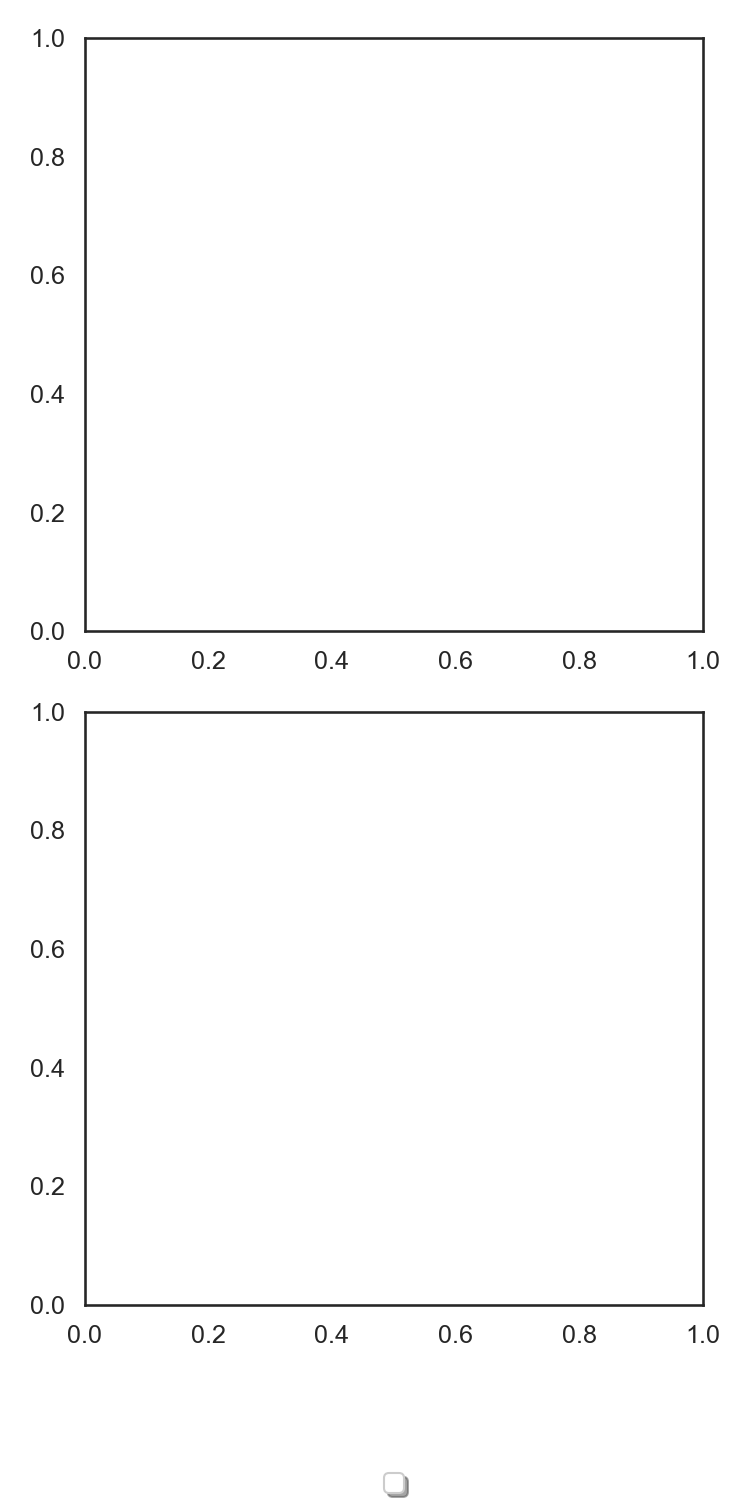

In [30]:
trajs = trajectories.keys()

ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
genes = pn.widgets.CheckBoxGroup(options=pathways[ticker.value])
int_slider = pn.widgets.IntSlider(name='Moving Average Window', start=5, 
                                  end=int(int(len(forebrain.obs)/4)/5)*5, step=5)

@pn.depends(ticker.param.value,watch=True)
def update_genes(ticker_val):
    genes.options=pathways[ticker.value]

@pn.depends(ticker.param.value, genes.param.value, int_slider.param.value)

def get_plot(ticker_val,genes_val, int_val):
    fig, axs=plt.subplots(len(trajs),1, figsize=(5,10))
    counter=0
    for traj_val in trajs:
        adata = forebrain[forebrain.obs['branch_id_alias'].isin(trajectories[traj_val])]
        df = adata.obs['S2_pseudotime'].to_frame()
        df['leiden'] = adata.obs['leiden']
        for i in genes_val:
            df[i] = adata.raw.X[0:,list(adata.var.index).index(i)]
        df = df.sort_values('S2_pseudotime')
        arrt = df['S2_pseudotime']
        avgt=arrt.rolling(int_val).mean()
        legend_elements=[]
        for j in genes_val:
            arrexp = df[j]
            avgexp = arrexp.rolling(int_val).mean()
            sem = arrexp.rolling(int_val).var()/np.sqrt(int_val)
            axs[counter].plot(avgt, avgexp)
            color=axs[counter].lines[-1].get_color()
            legend_elements.append(Line2D([0], [0], label = j, color=color))
            axs[counter].fill_between(avgt, (avgexp-sem), (avgexp+sem), color=color, alpha=0.2)
            axs[counter].set_title(traj_val)
            axs[counter].set_xlabel('Pseudotime')
            axs[counter].set_ylabel('Normalized Gene Expression')
        plt.legend(handles = legend_elements, loc='center', bbox_to_anchor=(0.5, -0.3),
                  fancybox=True,shadow=True, ncol=3)
        counter+=1
        plt.close()
    fig.tight_layout()
    plt.close()
    fig.savefig(figdir+"fig9_"+ticker_val+'_'+'.pdf')
    return fig

row = pn.Row(get_plot, pn.Spacer(width=15),pn.Column(pn.Spacer(height=50),pn.Column(int_slider,ticker,genes,css_classes=['panel-widget-box'])))

panel_layout = pn.Column(pn.pane.Markdown("##Figure 17: Gene Expression Over Developmental Time", 
                                          align="center", style={'font-family': 'Calibri, sans-serif'}), 
                         pn.pane.Markdown('For each trajectory we obtained from Slingshot, \
                                          we can visualize gene expression over pseudotime. Below is an \
                                          interactive panel to view expression of different genes of interest.\
                                          You can also change the \"moving averages\" parameter, which \
                                          averages over n number of points. The shaded area shows the standard error.',
                                         align='center', style={'font-family': 'Calibri, sans-serif'}),
                         row)
panel_layout